#  Differential equations

An equation relating one or more functions (or state variables) and their derivatives is known as a *differential equation*. They play a prominent role in natural sciences and engineering as exemplified by the heat equation

$$
\frac{\partial u}{\partial t} =
\alpha \Big(
\frac{\partial^2 u}{\partial x^2} +
\frac{\partial^2 u}{\partial y^2} +
\frac{\partial^2 u}{\partial z^2}
\Big)
$$

where $u(x,y,z,t)$ is the temperature at point $\mathbf{r} = (x,y,z)$ at time $t$ and $\alpha$ is a positive constant known as the thermal diffusivity of the medium.

## Finite difference method (FDM)

Numerical solutions are obtained by discretizing the functions in space and time and approximating derivatives with finite differences, e.g.,

$$
\frac{\partial u}{\partial t} \approx
\frac{u(t + \Delta t) - u(t)}{\Delta t} 
$$

and

\begin{align*}
\frac{\partial^2 u}{\partial x^2} & \approx
\Big(
\frac{u(x + \Delta x) - u(x)}{\Delta x} 
-
\frac{u(x) - u(x - \Delta x)}{\Delta x}  
\Big) / \Delta x
\\ & =
\frac{u(x + \Delta x) - 2 u(x) + u(x - \Delta x)}{(\Delta x)^2} 
\end{align*}

Providing initial values for the functions allows us to propogate the differential equation.

## Model heat transfer through a wall

```{figure} ../images/wall-heat-transfer.*
---
name: heat-transfer-fig
width: 600px
align: center
---
Heat transfer through a wall as an example of solving the heat equation in 1D.
```

We write a `class` for a wall with heat transfer that stores the state variable $u(x)$ and contains a `method` to conduct an Euler step in the time propagation.

In [1]:
import numpy as np


class HeatTransferWall:
    def __init__(self, thickness, T_inside, T_outside, alpha=19, N=100):

        self.alpha = alpha  # diffusivity with default value for air
        self.number_elements = N
        self.dx = thickness / N

        # initialization of state variable u(x)
        self.x = np.linspace(0, thickness, N)
        self.u = np.ones(N) * T_outside
        self.u[0] = T_inside

    def step(self, dt=0.1):

        N = self.number_elements

        d2u_dx2 = np.zeros(N)
        d2u_dx2[1 : N - 1] = (
            self.u[2:N] - 2 * self.u[1 : N - 1] + self.u[0 : N - 2]
        ) / self.dx**2
        # Euler step
        self.u[1 : N - 1] = self.u[1 : N - 1] + self.alpha * d2u_dx2[1 : N - 1] * dt

Propagate the heat equation for 5 min in time steps of 0.1 sec.

In [2]:
wall = HeatTransferWall(200, 20, 0)

for i in range(3000):
    wall.step()

Plot the final state, $u(x, T)$.

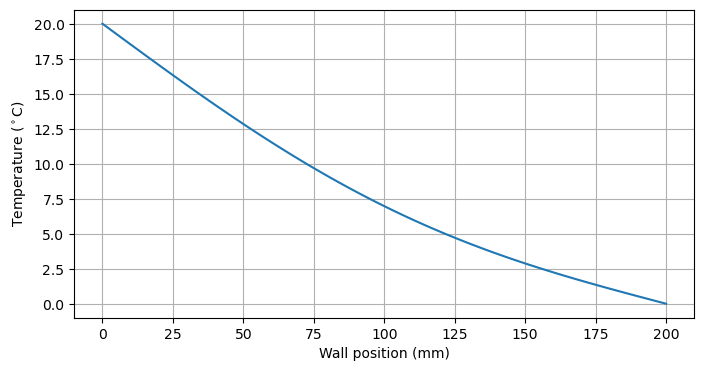

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 4))

plt.plot(wall.x, wall.u)

plt.grid("on")
plt.ylabel(r"Temperature ($^\circ$C)")
plt.xlabel("Wall position (mm)")

plt.show()

In this implementation, we did not save the intermediate states, $u(x,t)$ for $0 \leq t \leq T$, but it is of course straighforward to do so.

```{admonition} Bonus material: Plot animation
Alternatively, the time evolution of the state can be illustrated by means of an animation. Plot animations are available with use of `animation.FuncAnimation`. The key steps are to (i) enable an interactive plot, (ii) create a `Line2D` line object and (iii) write a function `plot_update` that updates the line object in every frame of the animation.
```

```
# enable an interactive plot
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

wall = HeatTransferWall(200, 20, 0)

fig = plt.figure(figsize = (8,4))
ax = plt.axes(xlim=(0, 200), ylim=(-1, 21))
ax.grid()

plt.ylabel(r'Temperature ($^\circ$C)')
plt.xlabel('Wall position (mm)')

# create line and text objects
line, = ax.plot(wall.x, wall.u, lw=2)
time_text = ax.text(130, 19, 'Time: 0 (sec)')

def plot_update(frame_number, wall, line, time_text):

    # perform a time step
    wall.step()
    
    # update properties of line and text objects
    line.set_data(wall.x, wall.u)
    time_text.set_text(f'Time: {frame_number} (sec)')

# run the animation
anim = FuncAnimation(fig, plot_update, fargs = [wall, line, time_text], frames = 3000, interval = 2)

plt.show()
```

```{figure} ../images/wall-animation.*
---
name: wall-animation-fig
width: 600px
align: center
---
Animation of heat transfer through a wall.
```

(sec:ode)=
## Ordinary differential equations (ODEs)

### Implicit form

In describing the dynamics of biological system, we are typically concerned with *[ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation)* (ODEs) in which case the state variables are functions of time only and partial derivatives are replaced by "ordinary" derivatives. A system of *implicit* ODEs may be quite generally written

$$
\mathbf{F}(\mathbf{y}', \mathbf{y}, t) = 0
$$

where $\mathbf{y}$ is the array collecting the set of state variables, $\mathbf{y}'$ denotes its time derivative, and $\mathbf{F}$ is the array collecting the set of scalar equations. 

It may at first sight appear limiting not to consider higher-order derivatives of $\mathbf{y}$, such as the second-order derivative $\mathbf{y}''$, as arguments of $\mathbf{F}$. However, an ODE of order greater than one can be re-written as a system of ODEs of first order. As an illustration, let us consider the second-order differential equation describing the Newtonian mechanics of a damped harmonic oscillator

$$
m \frac{d^2 x}{d t^2} = -c \frac{d x}{d t} - k x
$$

where $k$ is the spring constant and the friction, or damping, is proportional to the velocity of the particle. Let us introduce

\begin{align*}
y_1 & = x \\
y_2 & = x'
\end{align*}

which transforms the one-dimensional second-order differential equation into a two-dimensional first-order differential equation according to

\begin{align*}
y_1' & = y_2 \\
y_2' & = -\frac{c}{m} y_2 - \frac{k}{m} y_1
\end{align*}

### Explicit form

Less general than the implicit case, an *explicit* system of ODE takes the form

$$
\mathbf{y}' = \mathbf{F}(\mathbf{y}, t) 
$$

where it is thus required that the equations are linear in $\mathbf{y}'$. 

The Lotka–Volterra (or predator–prey) equations represents an example of an explicit system of ODEs.

\begin{align*}
\frac{dy_1}{dt} & = \alpha y_1 - \beta y_1 y_2 \qquad \mathsf{(Prey)}\\
\frac{dy_2}{dt} & = \delta y_1 y_2 - \gamma y_2  \qquad \mathsf{(Predator)}
\end{align*}

where $\mathbf{y} = (y_1, y_2)$.



### Model design

Designing a model to describe a real-world situation refers to the introduction of a canonical set of state variables, their couplings and parameters, and relating the parameters to actual conditions.

E.g. we may wish to embed the following facts into the model:

- Prey has one offspring per year, i.e., $\alpha = \mathrm{ln}(2)$
- Predator has at most one offspring per year but fewer when prey is short, i.e., $\delta y_1 = \min(\mathrm{ln}(2), \delta y_1)$

## Numerical solutions

### Euler's method

Knowledge of the state variables collected in $\mathbf{y}$ at some time $t_0$ makes it straightforward to find a numerical solution to an explicit system of ODEs. We discretize time and use a differential approximation of the derivative according to

$$
\mathbf{y}(t + \Delta t) = \mathbf{y}(t)  +
\mathbf{F}(\mathbf{y}, t) \Delta t 
$$

This approach is called the [Euler method](https://en.wikipedia.org/wiki/Euler_method) and we shall illustrate its use by finding a solution to the Lotka–Volterra equations. In doing so, we will also take the opportunity to illustrate that Python naturally invites to good software engineering practices in terms of [object-oriented programming](https://www.w3schools.com/python/python_classes.asp).

In [4]:
class PredatorPreyModel:
    def __init__(self, y0, alpha, beta, delta, gamma):
        """
        Model parameters:
        =================
        y0: initial (predator, prey) populations

        alpha: prey growth rate
        beta: prey death rate
        delta: predator growth rate
        gamma: predator death rate
        """
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta

        self.preys = [y0[0]]
        self.predators = [y0[1]]

    def euler_step(self, dt):

        y1 = self.preys[-1]
        y2 = self.predators[-1]

        delta = self.delta
        if delta * y1 > np.log(2):
            delta = np.log(2) / y1

        y1_new = y1 + (self.alpha * y1 - self.beta * y1 * y2) * dt
        y2_new = y2 + (delta * y1 * y2 - self.gamma * y2) * dt

        self.preys.append(y1_new)
        self.predators.append(y2_new)

First, we discretize time.

In [5]:
import numpy as np

In [6]:
years = 25
N = 5000  # number of steps

In [7]:
t = np.linspace(0, 25, num=N)  # time in unit of years
dt = years / N  # time step in numerical integration

Second, we create an object of the `PredatorPreyModel` class and time propagate with the Euler method that is implemented into the `PredatorPreyModel` class.

In [19]:
alpha, beta, delta, gamma = (np.log(2), 0.1, 0.002, 0.2)

y0 = (100, 6)  # initial values of y = (y1, y2)

ppm = PredatorPreyModel(y0, alpha, beta, delta, gamma)

for i in range(N - 1):
    ppm.euler_step(dt)

Third, we plot the prey and predator populations. 

In [20]:
import matplotlib.pyplot as plt

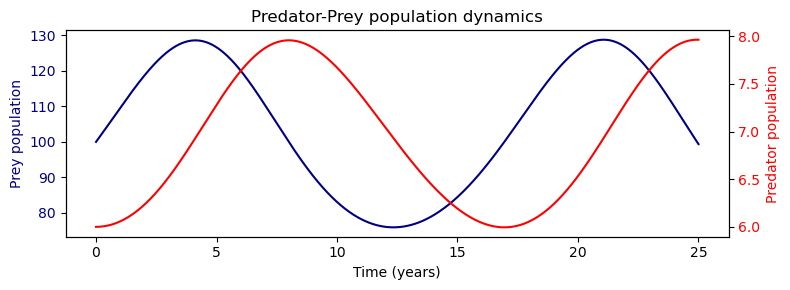

In [21]:
fig, ax1 = plt.subplots(figsize=(8, 3))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax1.plot(t, ppm.preys, color="navy", label="Prey")
ax2.plot(t, ppm.predators, color="red", label="Predator")

ax1.set_title("Predator-Prey population dynamics")
ax1.set_ylabel(r"Prey population", color="navy")
ax2.set_ylabel(r"Predator population", color="red")
ax1.set_xlabel(r"Time (years)")

ax1.tick_params(axis="y", labelcolor="navy")
ax2.tick_params(axis="y", labelcolor="red")

fig.tight_layout()

plt.show()

### ODE solver library

The SciPy library comes with an [ODE solver](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html) named `odeint` that serves as an alternative.

The basic need of `odeint` is for the user to implement a function that returns the array $\mathbf{y}'(t)$. This function is thereafter passed as an argument to `odeint` together with the initial values of $\mathbf{y}$ and the additional arguments of the function.

In [11]:
def lotka_volterra(y, t, alpha, beta, delta, gamma):
    y1, y2 = y

    if delta * y1 > np.log(2):
        delta = np.log(2) / y1

    dydt = [alpha * y1 - beta * y1 * y2, delta * y1 * y2 - gamma * y2]

    return dydt

In [12]:
from scipy.integrate import odeint

y = odeint(lotka_volterra, y0, t, args=(alpha, beta, delta, gamma))

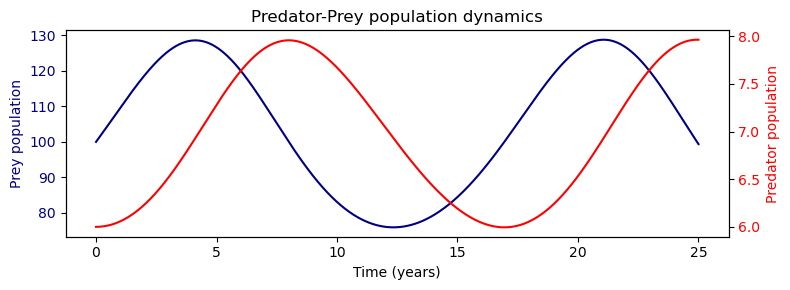

In [13]:
fig, ax1 = plt.subplots(figsize=(8, 3))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax1.plot(t, ppm.preys, color="navy", label="Prey")
ax2.plot(t, ppm.predators, color="red", label="Predator")

ax1.set_title("Predator-Prey population dynamics")
ax1.set_ylabel(r"Prey population", color="navy")
ax2.set_ylabel(r"Predator population", color="red")
ax1.set_xlabel(r"Time (years)")

ax1.tick_params(axis="y", labelcolor="navy")
ax2.tick_params(axis="y", labelcolor="red")

fig.tight_layout()

plt.show()

We note that the `odeint` and Euler solutions are in perfect agreement.

## Analysis of solutions
While it is most natural to present the solutions to ODEs in terms of plots of state variables with respect to time, it can be revealing to plot solutions parametrically as [orbitals](https://en.wikipedia.org/wiki/Orbit_(dynamics)) in [phase space](https://en.wikipedia.org/wiki/Phase_space). Let us consider the solutions to our predator–prey model with vaying initial populations.

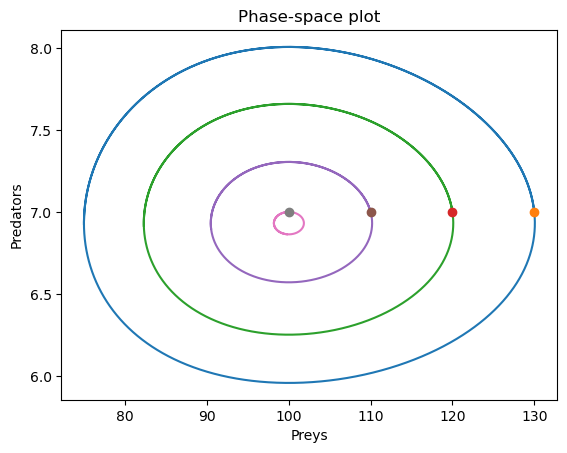

In [14]:
plt.title("Phase-space plot")

plt.ylabel(r"Predators")
plt.xlabel(r"Preys")

y0_l = [[130, 7],[120, 7],[110, 7],[100, 7],]

for y0 in y0_l:

    y = odeint(lotka_volterra, y0, t, args=(alpha, beta, delta, gamma))

    plt.plot(y[:, 0], y[:, 1], "-")
    plt.plot(y[0, 0], y[0, 1], "o")

plt.show()

The initial populations are depicted by the solid circles in the figure and the orbitals in phase space become gradually smaller, which corresponds to reduced variations in the populations. There appears to be a central point for which populations are static (not changing in time). This point correspond mathematically to a point where the array of derivatives of the Lotka–Volterra equation is zero:

\begin{align*}
\alpha  y_1 - \beta y_1 y_2 & = 0 \\
\delta y_1 y_2 - \gamma y_2 & = 0
\end{align*}

This set of equations has one trivial solution in terms of zero populations but also one nontrivial solution given by

$$
y_1 = \frac{\gamma}{\delta}; \quad y_2 = \frac{\alpha}{\beta}
$$

With our choice of rate parameters, we get

In [15]:
print(f"Stable prey population    : {gamma/delta:6.1f}")
print(f"Stable predator population: {alpha/beta:6.1f}")

Stable prey population    :  100.0
Stable predator population:    6.9


## Forming your project

You are encouraged to develop your own model. Inspiration and examples are found in the course book by Herod and Shonkwiler {cite}`Shonkwiler2009`.

1. **Interactions Between Organisms and Their Environment** <br> 
An ecosystem is a group of interacting living and nonliving elements. Every real organism sits in such a mixture of living and nonliving elements, interacting with them all at once. A famous biologist, Barry Commoner, has summed this up with the observation that “Everything is connected to everything else." Living components of an organism’s environment include those organisms that it eats, those that eat it, those that exchange diseases and parasites with it, and those that try to occupy its space. Chapters 3 and 4 in the course book by Herod and Shonkwiler {cite}`Shonkwiler2009` serve as an introduction.

2. **Diffusion and membrane transport** <br>
Many biological phenomena, at all levels of organization, can be modeled by treating them as random processes, behaving much like the diffusion of ink in a container of water. The transmembrane movement of the normal water-soluble compounds of cellular metabolism is regulated by large biochemical molecules that span the membrane. They are called permeases, or transport proteins. Permeases have the ability to select the materials that cross a membrane. Chapter 6 in the course book by Herod and Shonkwiler {cite}`Shonkwiler2009` serves as an introduction. 

3. **Communication and signaling in organisms** <br>
Neurons are separated by a synaptic cleft, and interneuronal transmission of information is chemically mediated. An action potential in a presynaptic neuron triggers the release of a neurotransmitter chemical that diffuses to the postsynaptic cell. The sum of all the excitatory and inhibitory neurotransmitters that reach a postsynaptic cell in a short period of time determines whether a new action potential is generated. Chapter 7 in the course book by Herod and Shonkwiler {cite}`Shonkwiler2009` serves as an introduction.

4. **Enzyme kinetics** <br>
Enzymes serve to catalyze reactions in living systems, enabling complex chemical transformations to occur at moderate temperatures, many times faster than their uncatalyzed counterparts. Proteins, serving as the catalysts, are first used and then regenerated in a multistep process. Overall, the simplest enzyme-catalyzed reactions transform the enzyme’s specific substrate into product, possibly with the release of a by-product. Referred to as enzyme saturation, these reactions are typically rate limited by the amount of enzyme itself. Chapter 8 in the course book by Herod and Shonkwiler {cite}`Shonkwiler2009` serves as an introduction.

5. **Uptake of lead in mammals** <br>
While lead interacts differently with the various tissues of the body, as a first approximation we need only distinguish three tissue types: bone, blood, and the other soft tissue of the body. Bone tends to take up lead slowly but retain it for very long periods of time, in contrast to soft tissue, other than blood, in which the turnover of lead is much quicker. Blood is the transport agent of the metal. The disposition of lead in the body can be followed as a three-compartment system by tracking its movement into and out of these three tissue types. Chapter 9 in the course book by Herod and Shonkwiler {cite}`Shonkwiler2009` serves as an introduction.

6. **T-cell infection by HIV** <br>
You could think of a question related to HIV infection and treatment, introducing three types of T-cells (normal, latent and active) and the virus to model as particles that interact according to rules that are similar to real life. Chapter 10 in the course book by Herod and Shonkwiler {cite}`Shonkwiler2009` serves as an introduction.